In [5]:
import json
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import RectBivariateSpline

In [6]:
with open('data/Tracking_example_data_1.json', 'r') as file:
    data = json.load(file)

Layout of the data in the sample boat tracking information

In [7]:
print(data['schema'])
print(data['dframes'][0])

['_lat', '_lon', 'cog', 'sog', 'heading', 'pitch', 'roll', 'wspeed', 'wangle', 'twspeed', 'twangle', 'twdirection', 'vmg']
[-41.285089169939866, 174.79663346037051, 72.2, 5.6, 69.9, 2.6, 2.9, 22.08, -67.2, 18.57, -86.2, 345.4, 0.37]


For a very basic performance analysis twspeed, twangle, vmg are required

In [8]:
minimum_properties = ['twspeed', 'twangle', 'vmg']
indices = [data['schema'].index(property) for property in minimum_properties]
filtered_dframes = [[row[i] for i in indices] for row in data['dframes']]
basic_analysis_data = {
    "schema": minimum_properties,
    "dframes": filtered_dframes
}

In [9]:
print(basic_analysis_data['schema'])
print(basic_analysis_data['dframes'][0])

['twspeed', 'twangle', 'vmg']
[18.57, -86.2, 0.37]


Now, add the specific boat type ORC certified polars (a csv file from https://jieter.github.io/orc-data/site/index.html#AUS/7183)

In [10]:
polars_df = pd.read_csv('data/J112E_polars.csv', delimiter=';')
print(polars_df)

   twa/tws     6     8    10    12    14    16     20     24
0        0  0.00  0.00  0.00  0.00  0.00  0.00   0.00   0.00
1       52  5.58  6.58  7.14  7.38  7.50  7.56   7.63   7.62
2       60  5.87  6.82  7.32  7.57  7.70  7.78   7.88   7.87
3       75  6.07  6.97  7.45  7.76  7.98  8.13   8.31   8.40
4       90  6.02  7.07  7.50  7.80  8.10  8.36   8.74   8.98
5      110  6.15  7.24  7.79  8.18  8.45  8.69   9.15   9.58
6      120  6.02  7.16  7.77  8.26  8.69  9.08   9.75  10.44
7      135  5.42  6.70  7.48  8.01  8.53  9.10  10.56  12.60
8      150  4.59  5.79  6.78  7.44  7.83  8.19   8.98  11.51


Interpolate or smooth the polar values. It seems like bilinear interpolation (2D grid) would be most suited in this instance as we want to interpolate both across TWA and TWS at the same time.

Note. Notice the 0 values in the polars. These should be accounted for before performing interpolation as they should be excluded from the interpolation

In [11]:
polars_df.replace(0, np.nan, inplace=True)
polars_df.dropna(how='all', inplace=True)

Now it is possible to setup this data for the interpolation

Setup the 2D grid

In [12]:
# Set up TWA and TWS for the grid and extract boat speed data
twa = polars_df.columns[1:].astype(float).values
tws = polars_df.iloc[1:, 0].astype(float).values
boat_speeds = polars_df.iloc[1:, 1:].values.astype(float)
boat_speeds[np.isnan(boat_speeds)] = np.nanmean(boat_speeds)

# Ensure TWA and TWS are strictly increasing
twa, unique_twa_indices = np.unique(twa, return_index=True)
tws, unique_tws_indices = np.unique(tws, return_index=True)
boat_speeds = boat_speeds[np.ix_(unique_tws_indices, unique_twa_indices)]

In [13]:
# Set up RectBivariateSpline for interpolation
spline = RectBivariateSpline(tws, twa, boat_speeds)
# Interpolate for each TWS and TWA pair in basic analysis data
basic_tws = [row[0] for row in basic_analysis_data['dframes']]
basic_twa = [row[1] for row in basic_analysis_data['dframes']]
interpolated_speeds = spline.ev(basic_tws, basic_twa)

In [14]:
# Add the interpolated speeds to the basic analysis data
for i, row in enumerate(basic_analysis_data['dframes']):
    row.append(interpolated_speeds[i])
basic_analysis_data['schema'].append('interpolated_speed')

# Create a fine grid for a full interpolated speed display
twa_fine = np.linspace(np.min(twa), np.max(twa), 50)
tws_fine = np.linspace(np.min(tws), np.max(tws), 50)
z_fine = spline(tws_fine, twa_fine)

In [15]:
# Create a DataFrame for the interpolated speed grid
df_grid = pd.DataFrame(z_fine, index=tws_fine, columns=twa_fine)
# Print the DataFrame with rounded values
print("Interpolated Speed Grid")
print(df_grid.round(2))

Interpolated Speed Grid
            6.000000   6.367347   6.734694   7.102041   7.469388   7.836735   \
60.000000        5.87       6.09       6.28       6.46       6.62       6.76   
61.836735        5.93       6.14       6.33       6.50       6.65       6.79   
63.673469        5.98       6.18       6.36       6.53       6.68       6.82   
65.510204        6.01       6.21       6.39       6.55       6.70       6.84   
67.346939        6.04       6.23       6.41       6.58       6.72       6.86   
69.183673        6.06       6.25       6.43       6.59       6.74       6.87   
71.020408        6.07       6.27       6.45       6.61       6.76       6.89   
72.857143        6.07       6.27       6.46       6.62       6.77       6.90   
74.693878        6.07       6.28       6.47       6.63       6.78       6.91   
76.530612        6.07       6.28       6.47       6.64       6.79       6.93   
78.367347        6.06       6.28       6.48       6.65       6.80       6.94   
80.204082       

Found a library that can read the ORC polars format directly. Will test this out.

hrosailing - https://hrosailing.github.io/hrosailing/hrosailing.html#version-0-1-0


In [16]:
from hrosailing.polardiagram._reading import from_csv

pd = from_csv("data/J112E_polars.csv", fmt="orc")
print(pd)

  TWA / TWS    6.0    8.0    10.0    12.0    14.0    16.0    20.0    24.0
+++++++++++  +++++  +++++  ++++++  ++++++  ++++++  ++++++  ++++++  ++++++
52.0          5.58   6.58    7.14    7.38    7.50    7.56    7.63    7.62
60.0          5.87   6.82    7.32    7.57    7.70    7.78    7.88    7.87
75.0          6.07   6.97    7.45    7.76    7.98    8.13    8.31    8.40
90.0          6.02   7.07    7.50    7.80    8.10    8.36    8.74    8.98
110.0         6.15   7.24    7.79    8.18    8.45    8.69    9.15    9.58
120.0         6.02   7.16    7.77    8.26    8.69    9.08    9.75   10.44
135.0         5.42   6.70    7.48    8.01    8.53    9.10   10.56   12.60
150.0         4.59   5.79    6.78    7.44    7.83    8.19    8.98   11.51



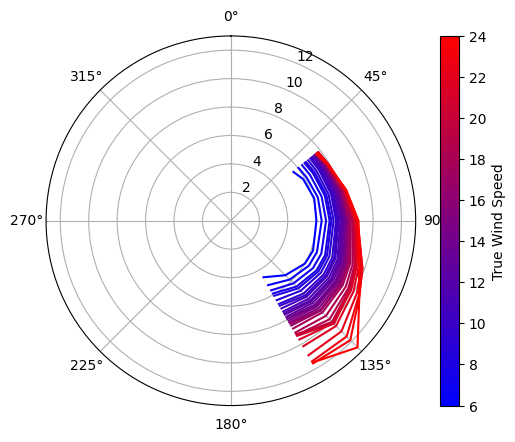

In [17]:
from hrosailing.plotting import plot_polar

plot_polar(pd, ws=[6, 24], n_steps=30, colors=('blue', 'red'), show_legend=True)